# Importation

In [1]:
import os
os.system('pip install pytorch_toolbelt')

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
from torch.autograd import Variable
from pytorch_toolbelt import losses as L

from transformers import AdamW
from transformers import get_linear_schedule_with_warmup

from sklearn.metrics import accuracy_score, f1_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

import math, copy, time
from tqdm.notebook import tqdm

  # Load the Data 

In [2]:
train = pd.read_csv("../input/data-without-noise/train_folds.csv") 
features = pd.read_csv('../input/data-without-noise/features.csv')
features = features.values
features = list(features.reshape(1,-1)[0])

# Dataset class 

In [3]:
class IC_Dataset() : 
    def __init__(self,df) :
        self.df = df 
        open_channels_col = [f'open_channels(t= {i})' for i in range(SEQ_LEN)]
        self.open_channels = df[open_channels_col].values
        
        data = dict()
        for f in features : 
          col = [f'{f}(t= {i})' for i in range(SEQ_LEN)]
          data[f] = df[col].values 
        
        self.data = data
        
    def __len__(self) : 
        return len(self.open_channels)
    def __getitem__(self,item) : 
        out = dict()
        out['open_channels'] = torch.tensor(self.open_channels[item],dtype=torch.long)
        x1 = torch.tensor(self.data[features[0]][item],dtype=torch.float).unsqueeze(1)
        for f in features[1:] : 
          x2 = torch.tensor(self.data[f][item],dtype=torch.float).unsqueeze(1)
          x1 = torch.cat([x1,x2],axis = 1)
        out['signal'] = x1 
        
        return out
        

# Model class 

## R-Transformer

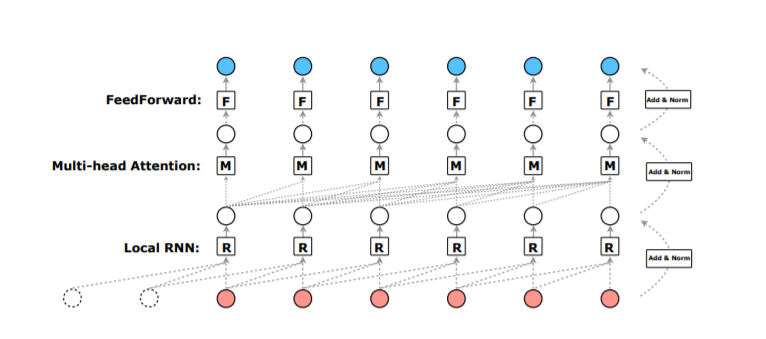

model paper  : https://arxiv.org/pdf/1907.05572v1.pdf 

**The illustraition of one layer of R-Transfprmer**: There are three different networks that are arranged hierarchically. 
* **The lower-level** : is localRNNs that process positions in a local window sequentially 

* **The middle-level** : is multi head attention networks which capteur the global long-term dependencies

* **The upper-level** :  is Position-wise feedforward networks that conduct non-linear feature transformation. 

These three networks are connected by a residual and layer normalization operation.

### Local RNN

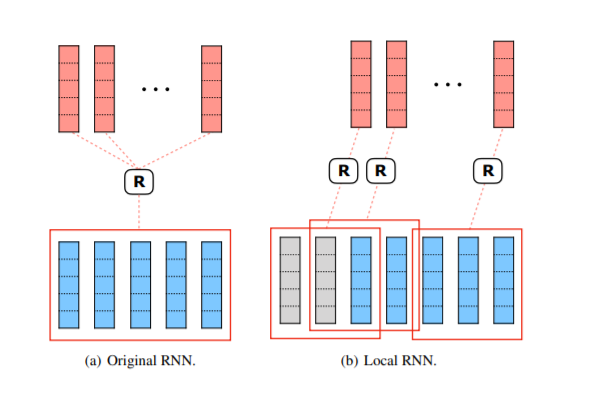

In constrat to original RNN which maitains a hidden state at each position summarizing all the inforamtion seen so far, LocalRNN only operates on positions within a local window. At each position, LocalRNN will produce a hidden state that represents the inforamtion in the loacl window ending at that position. Concretely, given the positions $x_{t-M-1},x_{t-M-2},...,x_{t} $ of a local short sequence of length M , the LocalRNN process the sequentially and outputs M hidden states, the last of which is used as the representation of the local short sequnces: 

$$h_t = LocalRNN(x_{t-M-1},x_{t-M-2},...,x_{t}) $$

RNNs have long been a dominating choice for sequence modeling but it severely suffers
from two problems – The first one is its limited ability to capture the long-term dependencies and the
second one is the time complexity, which is linear to the sequence length. However, in LocalRNN,
these problems are naturally mitigated. Because the LocalRNN is applied to a short sequence within
a local window of fixed size, where no long-term dependency is needed to capture. In addition, the
computation procedures for processing the short sequences are independent of each other. Therefore,
it is very straightforward for the parallel implementation (e.g., using GPUs), which can greatly
improve the computation efficiency.


### CAPTURING THE GLOBAL LONG-TERM DEPENDENCIES WITH MULTI-HEAD ATTENTION


Recent works have shown that the multi-head attention mechanism is extermely effective to learn the long-term dependencies, as it allows a direct connection between every pair of positions.More specifically , in the multihead attention mechnism, each position will attend to all the positions in the past and obtains a set of attention scores that are used to refine its representation.

##  OVERALL ARCHITECTURE OF R-TRANSFORMER

With all the aforementioned model components, we can now give a formal description of the overall
architecture of an N-layer R-Transformer. For the i
th layer (i ∈ {1, 2, · · · N}):


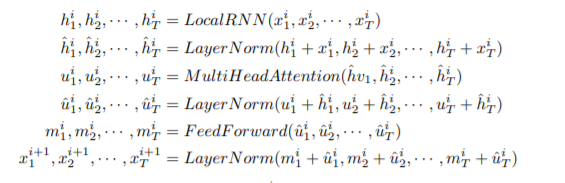

## Model implementation  

In [4]:
def clones(module, N):
    "Produce N identical layers."
    return nn.ModuleList([copy.deepcopy(module) for _ in range(N)])

In [5]:
class LayerNorm(nn.Module):
    "Construct a layernorm module."
    def __init__(self, features, eps=1e-6):
        super(LayerNorm, self).__init__()
        self.a_2 = nn.Parameter(torch.ones(features))
        self.b_2 = nn.Parameter(torch.zeros(features))
        self.eps = eps

    def forward(self, x):
        mean = x.mean(-1, keepdim=True)
        std = x.std(-1, keepdim=True)
        return self.a_2 * (x - mean) / (std + self.eps) + self.b_2

In [6]:
class SublayerConnection(nn.Module):
    """
    A residual connection followed by a layer norm.
    Note for code simplicity the norm is first as opposed to last.
    """
    def __init__(self, size, dropout):
        super(SublayerConnection, self).__init__()
        self.norm = LayerNorm(size)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, sublayer):
        "Apply residual connection to any sublayer with the same size."
        return x + self.dropout(sublayer(self.norm(x)))


In [7]:
class PositionwiseFeedForward(nn.Module):
    "Implements FFN equation."
    def __init__(self, d_model, dropout=0.1):
        super(PositionwiseFeedForward, self).__init__()
        d_ff = d_model * 4
        self.w_1 = nn.Linear(d_model, d_ff)
        self.w_2 = nn.Linear(d_ff, d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        return self.w_2(self.dropout(F.relu(self.w_1(x))))

In [8]:
def attention(query, key, value, mask=None, dropout=None):
    """
        Compute 'Scaled Dot Product Attention'
        query, key, value : batch_size, n_head, seq_len, dim of space
    """
 
    d_k = query.size(-1)
    # scores: batch_size, n_head, seq_len, seq_len
    scores = torch.matmul(query, key.transpose(-2, -1)) \
             / math.sqrt(d_k)
   
    if mask is not None:
        scores = scores.masked_fill(mask==0, -1e9)


    p_attn = F.softmax(scores, dim = -1)
    if dropout is not None:
        p_attn = dropout(p_attn)
    return torch.matmul(p_attn, value), p_attn


class MHPooling(nn.Module):
    def __init__(self, d_model, h, dropout=0.1):
        "Take in model size and number of heads."
        super(MHPooling, self).__init__()
        assert d_model % h == 0
        # We assume d_v always equals d_k
        self.d_k = d_model // h
        self.h = h
        self.linears = clones(nn.Linear(d_model, d_model), 4)
        self.attn = None
        self.dropout = nn.Dropout(p=dropout)

        #auto-regressive
        attn_shape = (1, 3000, 3000)
        subsequent_mask =  np.triu(np.ones(attn_shape), k=1).astype('uint8')
        self.mask = (torch.from_numpy(subsequent_mask) == 0).unsqueeze(1).cuda()
        
    def forward(self, x):
        "Implements Figure 2"

        nbatches, seq_len, d_model = x.shape
        
        # 1) Do all the linear projections in batch from d_model => h x d_k 
        query, key, value = \
            [l(x).view(nbatches, -1, self.h, self.d_k).transpose(1, 2)
             for l, x in zip(self.linears, (x, x, x))]
        
        # 2) Apply attention on all the projected vectors in batch. 
        x, self.attn = attention(query, key, value, mask=self.mask[:,:, :seq_len, :seq_len], 
                                 dropout=self.dropout)
        
        # 3) "Concat" using a view and apply a final linear. 
        x = x.transpose(1, 2).contiguous() \
             .view(nbatches, -1, self.h * self.d_k)
        return self.linears[-1](x)


In [9]:
class LocalRNN(nn.Module):
    def __init__(self, input_dim, output_dim, rnn_type, ksize, dropout):
        super(LocalRNN, self).__init__()
        """
        LocalRNN structure
        """
        self.ksize = ksize
        if rnn_type == 'GRU':
            self.rnn = nn.GRU(output_dim, output_dim, batch_first=True)
        elif rnn_type == 'LSTM':
            self.rnn = nn.LSTM(output_dim, output_dim, batch_first=True)
        else:
            self.rnn = nn.RNN(output_dim, output_dim, batch_first=True)

        self.output = nn.Sequential(nn.Linear(output_dim, output_dim), nn.ReLU())

        # To speed up
        idx = [i for j in range(self.ksize-1,10000,1) for i in range(j-(self.ksize-1),j+1,1)]
        self.select_index = torch.LongTensor(idx).cuda()
        self.zeros = torch.zeros((self.ksize-1, input_dim)).cuda()

    def forward(self, x):
        nbatches, l, input_dim = x.shape
        x = self.get_K(x) # b x seq_len x ksize x d_model
        batch, l, ksize, d_model = x.shape
        h = self.rnn(x.view(-1, self.ksize, d_model))[0][:,-1,:]
        return h.view(batch, l, d_model)

    def get_K(self, x):
        batch_size, l, d_model = x.shape
        zeros = self.zeros.unsqueeze(0).repeat(batch_size, 1, 1)
        x = torch.cat((zeros, x), dim=1)
        key = torch.index_select(x, 1, self.select_index[:self.ksize*l])
        key = key.reshape(batch_size, l, self.ksize, -1)
        return key


class LocalRNNLayer(nn.Module):
    "Encoder is made up of attconv and feed forward (defined below)"
    def __init__(self, input_dim, output_dim, rnn_type, ksize, dropout):
        super(LocalRNNLayer, self).__init__()
        self.local_rnn = LocalRNN(input_dim, output_dim, rnn_type, ksize, dropout)
        self.connection = SublayerConnection(output_dim, dropout)

    def forward(self, x):
        "Follow Figure 1 (left) for connections."
        x = self.connection(x, self.local_rnn)
        return x


In [10]:
class Block(nn.Module):
    """
    One Block
    """
    def __init__(self, input_dim, output_dim, rnn_type, ksize, N, h, dropout):
        super(Block, self).__init__()
        self.layers = clones(
            LocalRNNLayer(input_dim, output_dim, rnn_type, ksize, dropout), N)
        self.connections = clones(SublayerConnection(output_dim, dropout), 2)
        self.pooling = MHPooling(input_dim, h, dropout)
        self.feed_forward = PositionwiseFeedForward(input_dim, dropout)

    def forward(self, x):
        n, l, d = x.shape
        for i, layer in enumerate(self.layers):
            x = layer(x)
        x = self.connections[0](x, self.pooling)
        x = self.connections[1](x, self.feed_forward)
        return x
    


In [11]:
class RTransformer(nn.Module):
    """
    The overal model
    """
    def __init__(self, d_model, rnn_type, ksize, n_level, n, h, dropout):
        super(RTransformer, self).__init__()
        N = n
        self.d_model = d_model
        self.dropout = nn.Dropout(dropout)
        self.norm = LayerNorm(d_model)
        self.feed_forward = PositionwiseFeedForward(d_model, dropout)
        
        layers = []
        for i in range(n_level):
            layers.append(
                Block(d_model, d_model, rnn_type, ksize, N=N, h=h, dropout=dropout))
        self.forward_net = nn.Sequential(*layers) 

    def forward(self, x):
        x = self.forward_net(x)
        return x

In [12]:
class IC_RT(nn.Module):
    def __init__(self, input_size, d_model, output_size, h, rnn_type, ksize, n, n_level, dropout, emb_dropout):
        
        super(IC_RT, self).__init__()
        self.encoder = nn.Linear(input_size, d_model)
        self.rt = RTransformer(d_model, rnn_type, ksize, n_level, n, h, dropout)
        self.linear = nn.Linear(d_model, output_size)

    def forward(self, x) :
        
        x = self.encoder(x)
        output = self.rt(x)
        output = self.linear(output).double()
        
        return output

# Engine

In [13]:
def loss_fn(outputs, targets):
    return L.FocalLoss()(outputs, targets)

In [14]:
def train_fn(data_loader, model, optimizer):
  model.train()
  
  train_losses =[]
  train_preds, train_true = torch.Tensor([]).to(device), torch.LongTensor([]).to(device)
  for bi, d in tqdm(enumerate(data_loader), total=len(data_loader)):
    
    d['signal'] = d['signal'].to(device,dtype=torch.float)
    d['open_channels'] = d['open_channels'].to(device,dtype= torch.long)
    optimizer.zero_grad()
    
    predictions = model(d['signal'])
    predictions_ = predictions.reshape(-1, predictions.shape[-1])
    y_ = d['open_channels'].view(-1)
 
    loss = loss_fn(predictions_, y_)
    loss.backward()
    optimizer.step()

    train_losses.append(loss.item())

    train_true = torch.cat([train_true, y_], 0)
    train_preds = torch.cat([train_preds, predictions_.float()], 0)
     
  return train_losses,train_true,train_preds

In [15]:
def eval_fn(data_loader, model):
  model.eval()
  
  valid_losses=[]
  val_preds, val_true = torch.Tensor([]).to(device), torch.LongTensor([]).to(device)
  
  with torch.no_grad():
   
    for bi, d in tqdm(enumerate(data_loader), total=len(data_loader)):
      
      d['signal'] = d['signal'].to(device,dtype=torch.float)
      d['open_channels'] = d['open_channels'].to(device,dtype= torch.long)
    
      predictions = model(d['signal'])
      predictions_ = predictions.reshape(-1, predictions.shape[-1])
      y_ = d['open_channels'].view(-1)
      loss = loss_fn(predictions_, y_)
      
      valid_losses.append(loss.item())
        
      val_true = torch.cat([val_true, y_], 0)
      val_preds = torch.cat([val_preds, predictions_.float()], 0)
    
    return valid_losses, val_true ,val_preds

In [16]:
def predict(data_loader, model):
  model.eval()
  
  pred_list = []
  
  with torch.no_grad():
   
    for bi, d in tqdm(enumerate(data_loader), total=len(data_loader)):
      
      d['signal'] = d['signal'].to(device,dtype=torch.float)
    
      predictions = model(d['signal'])
      predictions_ = predictions.reshape(-1, predictions.shape[-1])

      
        
      pred_list.append(F.softmax(predictions_, dim=1).cpu().numpy())
    
    return pred_list

In [17]:
def run(model,train_dataset,valid_dataset,fold) : 
    it = 1 
    
  
    
    train_dataloader = DataLoader(train_dataset, NNBATCHSIZE, shuffle=True,num_workers = 16)

    
    valid_dataloader = DataLoader(valid_dataset, NNBATCHSIZE, shuffle=False)

    it = 0
    



    param_optimizer = list(model.named_parameters())
    no_decay = ["bias", "LayerNorm.bias", "LayerNorm.weight"]
    optimizer_parameters = [
        {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)], 'weight_decay': 0.001},
        {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)], 'weight_decay': 0.0},
    ]

    num_train_steps = int(len(train_dataloader)) * EPOCHS
    optimizer = AdamW(optimizer_parameters, lr=1e-5)
    scheduler = get_linear_schedule_with_warmup(
        optimizer,
        num_warmup_steps=0,
        num_training_steps=num_train_steps
    )

    avg_train_losses, avg_valid_losses = [], []
    best_f1 = 0 
    
    for epoch in range(EPOCHS):
      start_time = time.time()
      print('**********************************')
      print("Epoch : {}".format(epoch))
      train_losses,train_true,train_preds=train_fn(train_dataloader, model, optimizer)
      scheduler.step()
      train_loss = np.average(train_losses)
      avg_train_losses.append(train_loss)
      train_score = f1_score(train_true.cpu().detach().numpy(), train_preds.cpu().detach().numpy().argmax(1), labels=list(range(11)), average='macro')

      print( "train_loss: {:0.6f}, train_f1: {:0.6f}".format(train_loss, train_score))    
      
      valid_losses, val_true ,val_preds = eval_fn(valid_dataloader, model)
      valid_loss = np.average(valid_losses)
      avg_valid_losses.append(valid_loss)
      val_score = f1_score(val_true.cpu().detach().numpy(), val_preds.cpu().detach().numpy().argmax(1), labels=list(range(11)), average='macro')
      print( "valid_loss: {:0.6f}, valid_f1: {:0.6f}".format(valid_loss, val_score))
      if val_score > best_f1 : 
        best_f1 =  val_score
        torch.save(model.state_dict(), f'RT_Wave_best_{fold}.bin')
      
      print("--- %s seconds ---" % (time.time() - start_time))
      torch.save(model.state_dict(), f"RT_Wave_{fold}.bin")
    return avg_train_losses,avg_valid_losses,best_f1

# Model Training 

In [18]:
# config 
import random
EPOCHS = 24
NNBATCHSIZE = 2

device = torch.device("cuda")
SEED = 1234
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True 

In [19]:
def run_fold(fold) : 
    
    df_valid = train[train['kfold']==fold]
    df_train = train[train['kfold']!=fold]
    
    train_dataset = IC_Dataset(df_train)
    valid_dataset = IC_Dataset(df_valid)

    model = IC_RT(len(features),64,11,8,'GRU',6,12,3,0.3,0.2)
    model = model.to(device)
    
    _,_,best = run(model,train_dataset,valid_dataset,fold)
    
    return best

In [20]:
SEQ_LEN = 2500
best = run_fold(3)

**********************************
Epoch : 0



train_loss: 3.079400, train_f1: 0.193617



valid_loss: 0.633644, valid_f1: 0.404665
--- 239.7787263393402 seconds ---
**********************************
Epoch : 1



train_loss: 0.994050, train_f1: 0.360875



valid_loss: 0.426725, valid_f1: 0.493622
--- 239.84959721565247 seconds ---
**********************************
Epoch : 2



train_loss: 0.763133, train_f1: 0.439095



valid_loss: 0.337372, valid_f1: 0.572863
--- 239.8042242527008 seconds ---
**********************************
Epoch : 3



train_loss: 0.616899, train_f1: 0.495699



valid_loss: 0.263407, valid_f1: 0.631174
--- 242.59084558486938 seconds ---
**********************************
Epoch : 4



train_loss: 0.488859, train_f1: 0.554665



valid_loss: 0.191692, valid_f1: 0.701788
--- 241.54694771766663 seconds ---
**********************************
Epoch : 5



train_loss: 0.371218, train_f1: 0.623404



valid_loss: 0.135555, valid_f1: 0.780914
--- 242.68329763412476 seconds ---
**********************************
Epoch : 6



train_loss: 0.272543, train_f1: 0.697716



valid_loss: 0.100232, valid_f1: 0.851718
--- 241.97649574279785 seconds ---
**********************************
Epoch : 7



train_loss: 0.074167, train_f1: 0.933943



valid_loss: 0.060657, valid_f1: 0.939223
--- 242.78993487358093 seconds ---
**********************************
Epoch : 19


In [21]:
print('best fold 3 : ',best )

best fold 3 :  0.939255774483767


In [22]:
SEQ_LEN = 2500
best = run_fold(2)

**********************************
Epoch : 0



train_loss: 2.114528, train_f1: 0.255507



valid_loss: 0.531268, valid_f1: 0.475536
--- 243.125390291214 seconds ---
**********************************
Epoch : 1



train_loss: 0.833798, train_f1: 0.416828



valid_loss: 0.346686, valid_f1: 0.599247
--- 241.70956945419312 seconds ---
**********************************
Epoch : 2



train_loss: 0.621704, train_f1: 0.496630



valid_loss: 0.256494, valid_f1: 0.666862
--- 244.39135217666626 seconds ---
**********************************
Epoch : 3



train_loss: 0.482518, train_f1: 0.564150



valid_loss: 0.186538, valid_f1: 0.734935
--- 244.44292521476746 seconds ---
**********************************
Epoch : 4



train_loss: 0.368779, train_f1: 0.634235



valid_loss: 0.138571, valid_f1: 0.804086
--- 244.05659461021423 seconds ---
**********************************
Epoch : 5



train_loss: 0.279027, train_f1: 0.702046



valid_loss: 0.109502, valid_f1: 0.857743
--- 243.26637959480286 seconds ---
**********************************
Epoch : 6



train_loss: 0.076910, train_f1: 0.933273



valid_loss: 0.064421, valid_f1: 0.937218
--- 242.28498029708862 seconds ---
**********************************
Epoch : 17



train_loss: 0.067796, train_f1: 0.936364


In [23]:
print('best fold 2 : ',best )

best fold 2 :  0.9375522004703488
